In [4]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False



file_path = "c:/cygwin64/home/charl/25CERN/CassetteReception/ROOTFiles/summary_of_v3a_TTU_modules.root"
#input("Please enter the file path") 
#current path to test file! "c:/cygwin64/home/charl/25CERN/CassetteReception/summary_of_v3a_TTU_modules.root" 

To Do:
    Fix the i vs v plot
    turn things into callable functions!!
    adcMeanCSV()
    acdStddCSV()
    acdPlot()
    addBranchToIVPlot()

In [5]:

file = uproot.open(file_path)
treekeys = file.keys()
treenames = [t[:-2] for t in treekeys]

tree_list = []
for treename in treenames:
    tree_list.append(f"{file_path}:{treename}")

module_df = pd.DataFrame(columns=['name', 'i_vs_v', 'adc_stdd', 'adc_mean'])
pdf_plots = PdfPages(f'{treenames[0]}_{treenames[-1][-4:]}plots.pdf')


In [6]:
#THIS ONE WORKS DONT DELETE IT
############ i vs v data formatting and csv ############


def rootToDict(modName, dataBranch):
        dict_mods = {'module_name':[], 'meas_v':[], 'meas_i':[]}
        list_y = [(i*(10**6)) for i in dataBranch["meas_i"].tolist()]
        for item in list_y[::-1]:
                if item == 0:
                        list_y.pop()
        list_x = dataBranch["meas_v"].tolist()[:len(list_y)] 

        dict_mods['module_name'].append(modName)
        dict_mods['meas_v'].append(list_x)
        dict_mods['meas_i'].append(list_y)
        
        dict_mods = {key: val for key, val in dict_mods.items() if val != 0}
        
        return dict_mods

def modToCSV(uprootedFile, modList): 
        for i in modList:
                dataframe = uprootedFile[str(i)].arrays(library = "pd")
                dataframe = dataframe.drop(columns=["adc_stdd","adc_mean"])
                dataframe.to_csv(f"CSVFiles/{i[:-2]}.csv", index = False)
        return 0

def dfToIVPlot(dataframe):
        for i in range(len(dataframe.index)): #i vs v plotting
                v_raw = dataframe['meas_v'].iloc[i]
                i_raw = dataframe['meas_i'].iloc[i]
                lab = dataframe['module_name'].iloc[i]
                #print("v_raw type: ", type(v_raw))
                #print("i_raw type: ", type(i_raw))
                
                plt.plot(v_raw, i_raw, marker = ".", linewidth = 1, markersize = 4, label = lab)
        plt.grid(which='minor', color="#D1D1D1", linestyle='-', axis = 'x')
        plt.grid(which='major', color="#454545", linestyle='-')
        plt.minorticks_on()
        plt.title("Current vs Voltage")
        plt.yscale("log")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (μA)")
        plt.xlim([0,1000])
        plt.legend(loc = 'lower right',bbox_to_anchor=(1.4,0))
        plt.savefig(f"Plots/{treenames[0]}_to_{treenames[-1][-4:]}_i_v.png", bbox_inches="tight")
        plt.show()
        return 0

def makeCSV(mod,idx,adc_type, adc_list):
        adc_df = pd.read_csv(f"CSVFiles/{mod}.csv")
        try:
                adc_df.insert(idx + 2, adc_type, adc_list)
                adc_df.to_csv(f"CSVFiles/{mod}.csv", index = False)
        except Exception as e:
                print("Warning: you are trying to make a file that already exits. Please delete any files that you wish to rewrite.", e)

                                
        
        #plots
def plotADC(mod,x,y_stdd,y_mean):
        fig, (ax_stdd, noise, ax_mean) = plt.subplots(3, sharex=True)
        for plt_type in [ax_stdd, noise, ax_mean]:
                if plt_type == ax_stdd:
                        y = y_stdd
                        plt_type.set_ylim(-2,10)
                        plt_type.yaxis.set_ticks(np.arange(-2, 10, 2))
                        plt_type.set_ylabel("Noise (-2 to 10)")
                elif plt_type == noise:
                        y = y_stdd
                        plt_type.set_ylim(-2,400)
                        plt_type.yaxis.set_ticks(np.arange(0, 402, 100))
                        plt_type.set_ylabel("Noise")
                elif plt_type == ax_mean:
                        y = y_mean
                        plt_type.set_ylim(-2,400)
                        plt_type.yaxis.set_ticks(np.arange(0, 402, 100))
                        plt_type.set_ylabel("Pedetance")
                
                #print(f"len x: {len(x)} \nlen y: {len(y)} \n \n")
                
                plt_type.scatter(x, y, s=5)
                plt_type.grid(visible=None, which='major', axis='both')
                plt_type.xaxis.set_ticks(np.arange(0, 250, 25))
                plt_type.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
                plt_type.grid(which='minor', color="#D1D1D1", linestyle='-', axis = 'x')
                plt_type.grid(which='major', color="#454545", linestyle='-')
        
        fig.suptitle(mod)
        fig.set_figwidth(9)
        plt.xlim([0,240])
        #######plt.figure(treenames[index_tree])
        #plt.savefig(f"Plots/{treenames[index_tree]}_adc.png")
        #######pdf_plots.savefig()
        #plt.close()
        plt.show()
        return 0

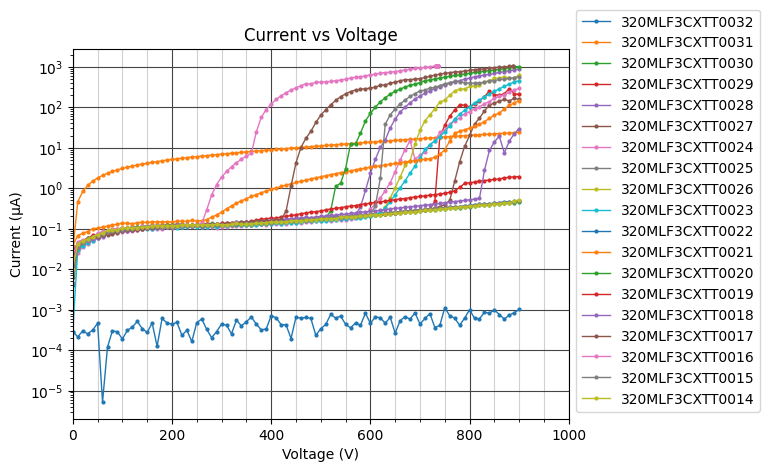

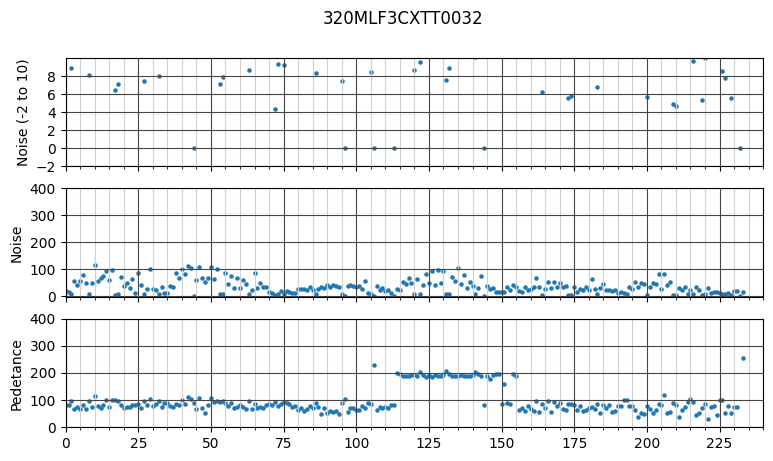

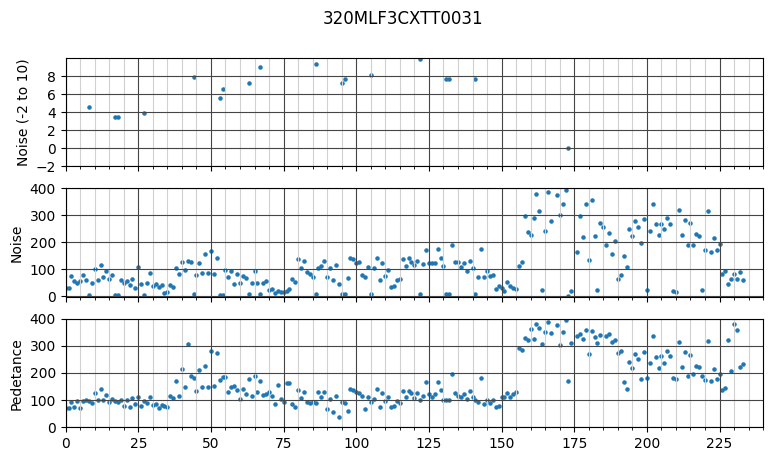

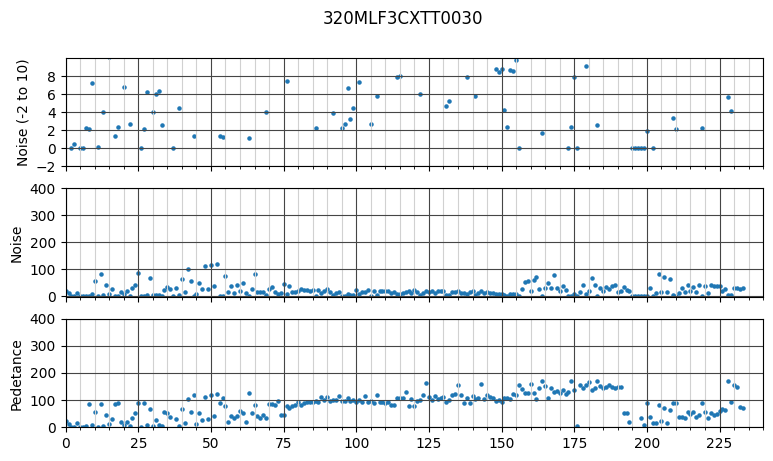

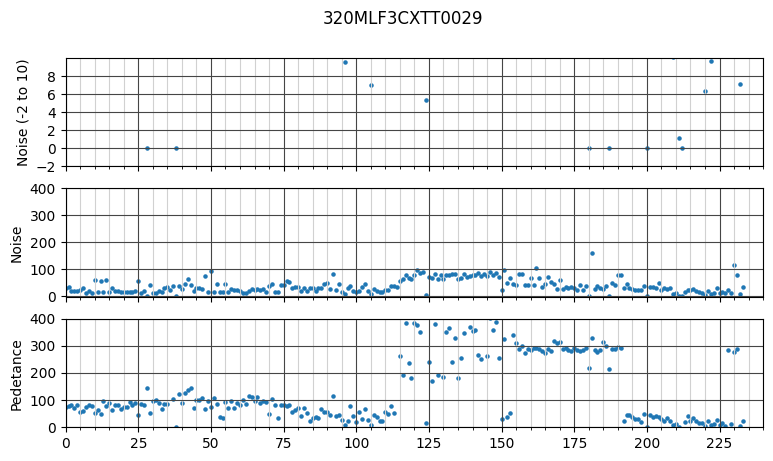

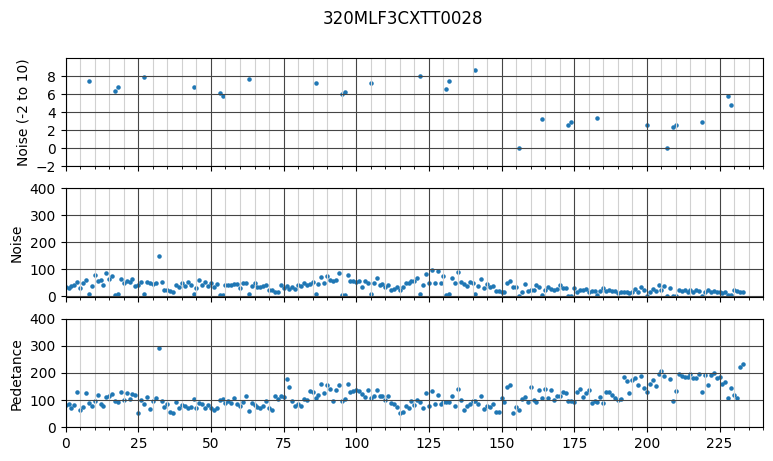

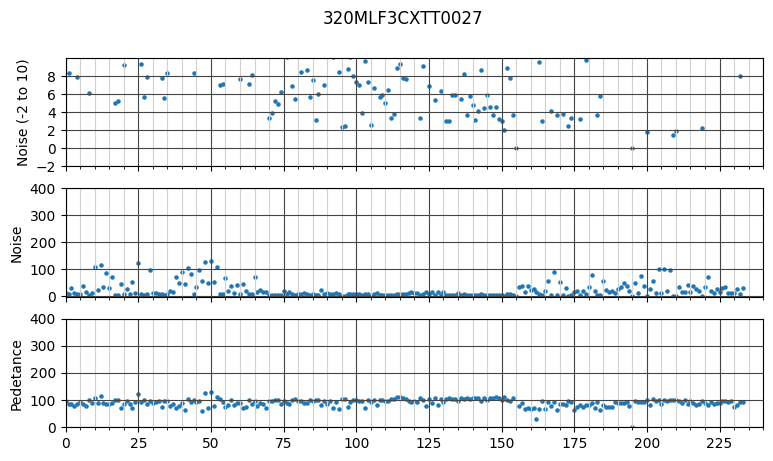

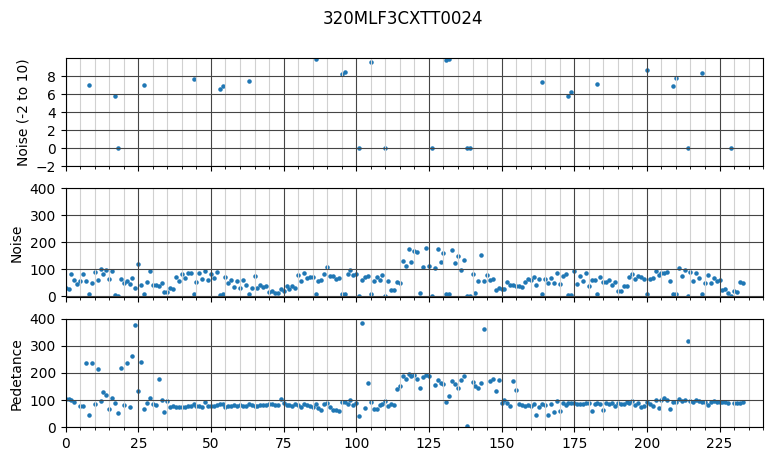

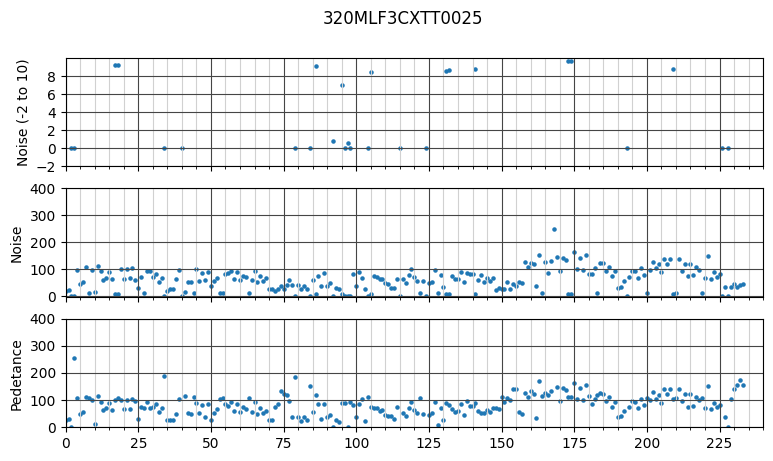

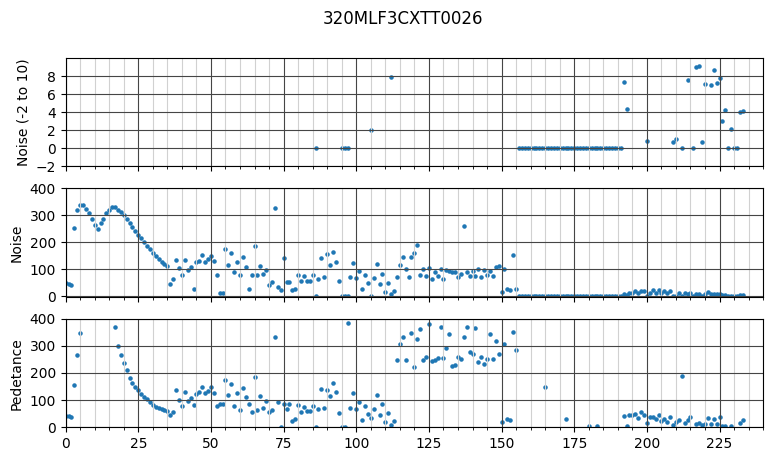

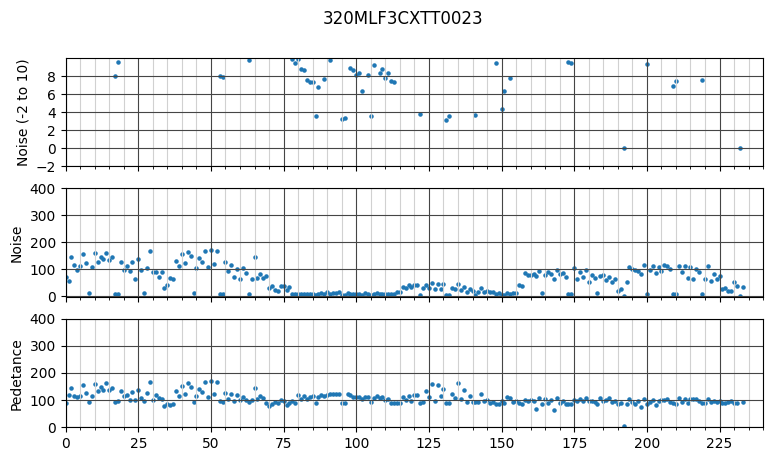

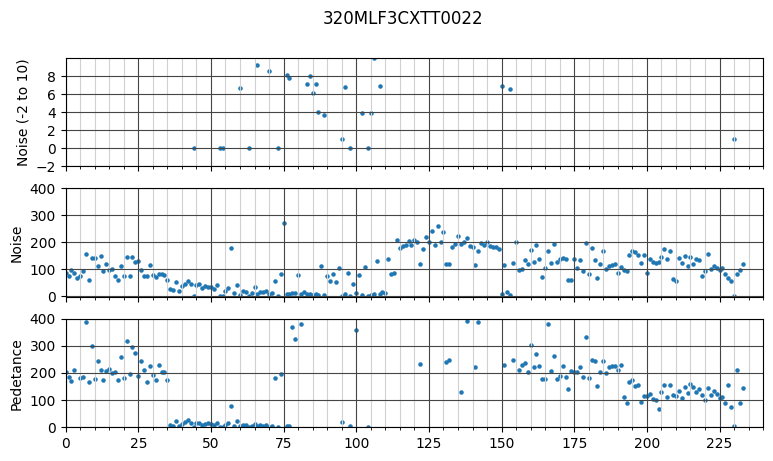

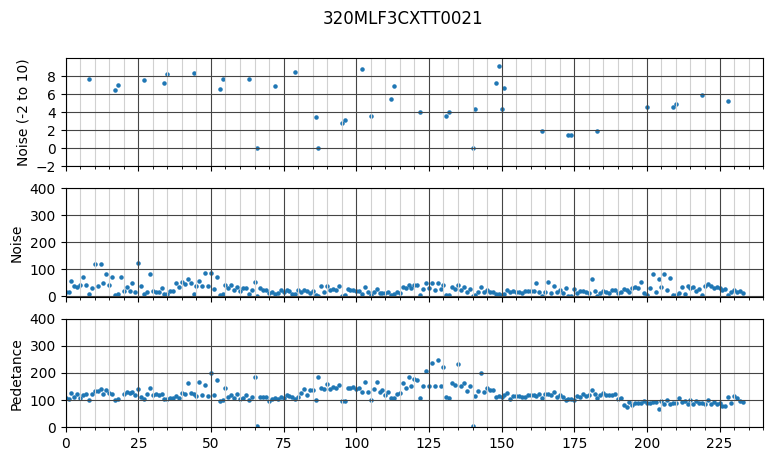

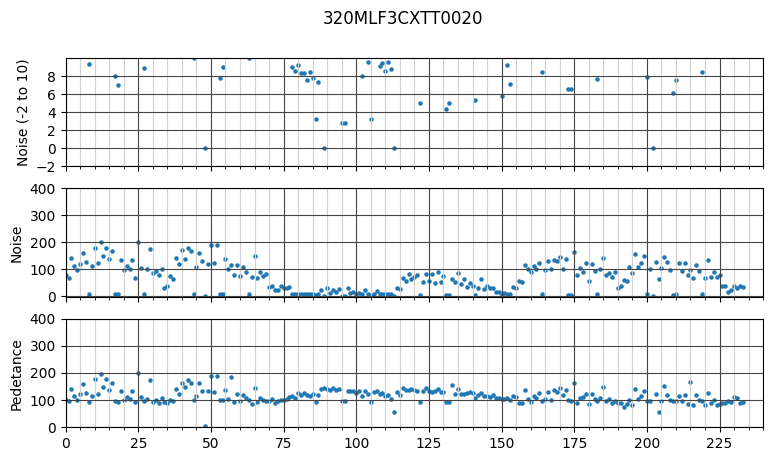

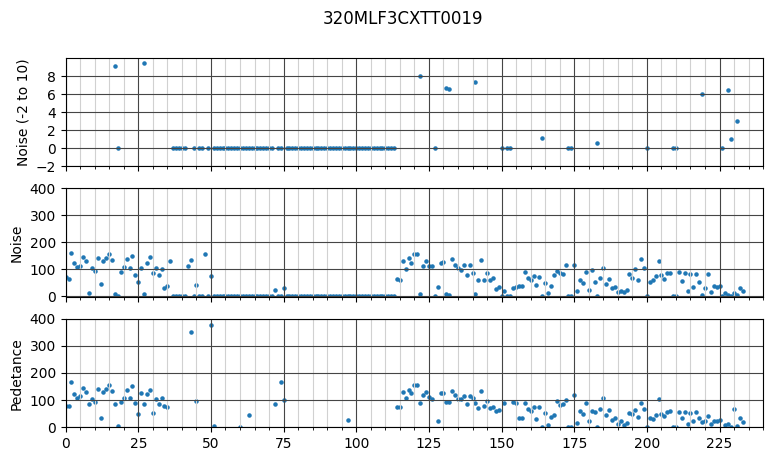

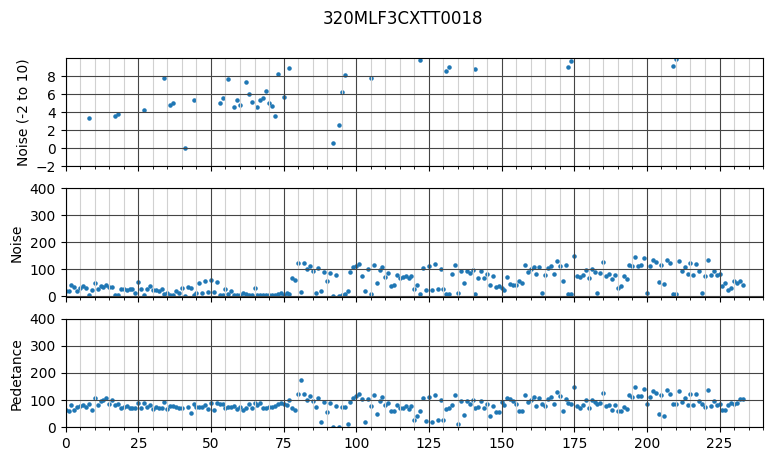

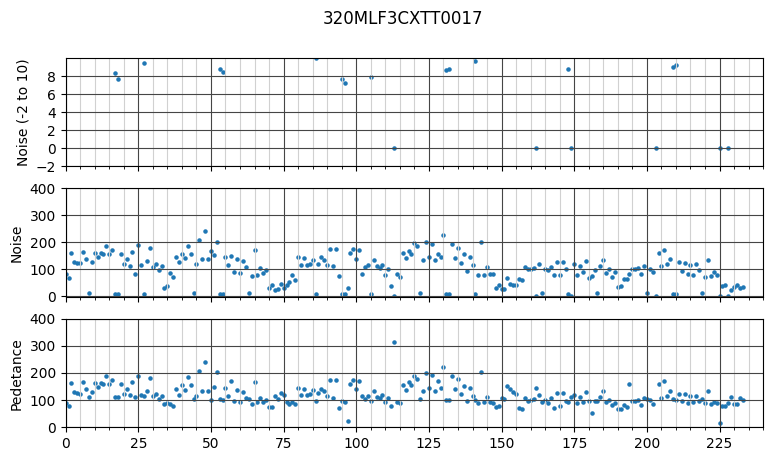

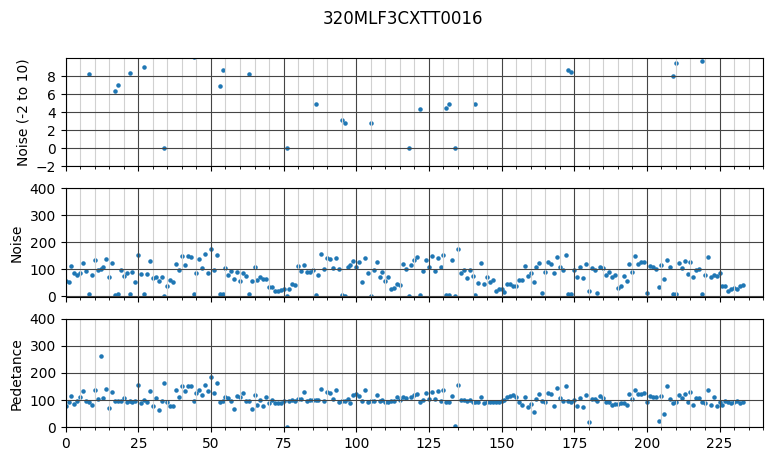

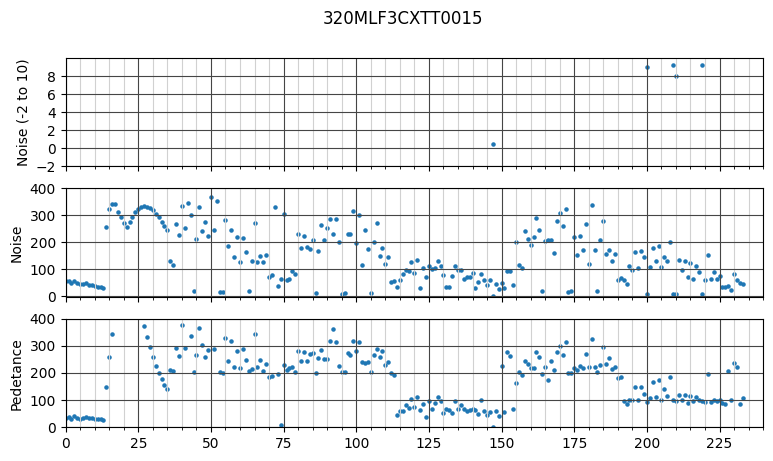

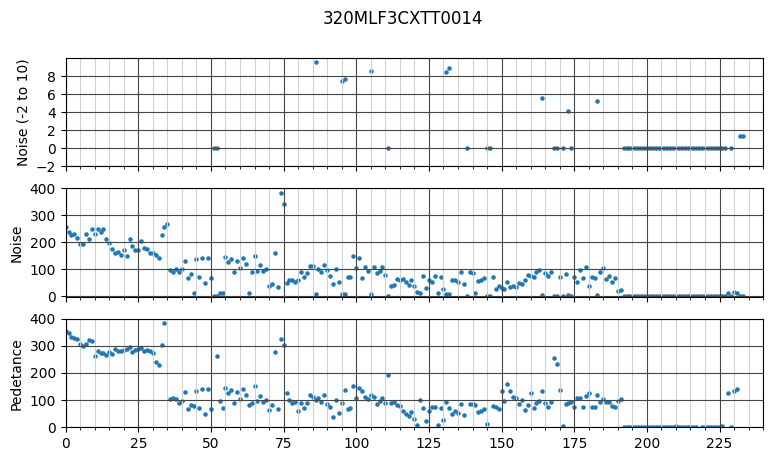

In [ ]:
dict_mods = {'module_name':[], 'meas_v':[], 'meas_i':[]}
i_v_df = pd.DataFrame()

for index_tree, branches in enumerate(uproot.iterate(tree_list)):    
        modToCSV(file,treekeys)
        dict_df = pd.DataFrame.from_dict(rootToDict(treenames[index_tree], branches))
        i_v_df = pd.concat([i_v_df, dict_df])

dfToIVPlot(i_v_df)

for index_tree, branch in enumerate(uproot.iterate(tree_list)):
        x = []
        y_mean = []
        y_stdd = []
        #y_type = [y_mean,y_stdd]
        #formatting data for plots and building csvs
        
        for idx, adc_type in enumerate(["adc_stdd", "adc_mean"]):
                adc_list = branch[adc_type]
                makeCSV(treenames[index_tree],idx, adc_type, adc_list)
                for index in range(234):
                        if adc_type == "adc_stdd":
                                y_stdd.append(adc_list[index])
                        else:
                                y_mean.append(adc_list[index])
                                x.append(index)
        
        plotADC(treenames[index_tree],x,y_stdd,y_mean)
                                


STEP 2!!!!!!!

In [ ]:
import pandas as pd
dataframe = file[str(treenames[0])].arrays(library = "pd")
dataframe = dataframe.drop(columns = ["adc_stdd", "adc_mean"])
#dataframe.to_csv("singleplot.csv", index = False)


#Currently specialized to the one practice plot lol


In [ ]:
pd.read_csv("singleplot.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'singleplot.csv'